In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentencepiece
!pip install optuna

import os
# import re
# import string
import codecs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from bs4 import BeautifulSoup

# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from sklearn.naive_bayes import MultinomialNB  # ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA, TruncatedSVD, SparsePCA, LatentDirichletAllocation
from sklearn.model_selection import KFold

from lightgbm import LGBMClassifier

import sentencepiece as spm
import optuna

     |████████████████████████████████| 1.1MB 12.4MB/s 
     |████████████████████████████████| 266kB 13.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 21.5MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 112kB 24.1MB/s 
     |████████████████████████████████| 133kB 13.1MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=0f5383237c8dd5f387f7f22d1577925313c9b387c0d1c73d19efa6d018492819
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=daaf5c81153b5309a73d1cd621cc83516a9f32abb1d4356abc6

In [ ]:
def seed_everything(seed=42):
  # random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  # tf.random.set_seed(seed)
  # torch.manual_seed(seed)
  # torch.cuda.manual_seed(seed)
  # torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

In [ ]:
DRIVE_PATH = "/content/drive/MyDrive/コンペ/ProbSpace/スパムメール判別"
DATA_DIR = os.path.join(DRIVE_PATH, "Data")

In [ ]:
# read csv ---------------------------------------------------------------------
original_train_df = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
original_test_df = pd.read_csv(os.path.join(DATA_DIR, "test_data.csv"))
train_df = original_train_df.copy()
test_df = original_test_df.copy()

# length -----------------------------------------------------------------------
train_length = len(original_train_df)
test_length = len(original_test_df)

# number of spam and ham -------------------------------------------------------
n_train_not_spam = 8707
n_train_spam = 171
n_test_not_spam = 7838
n_test_spam = 17000

test_not_spam_ration = n_test_not_spam/n_test_spam  # 7838 / 17000
test_spam_ration = n_test_spam / n_test_not_spam  # 17000 / 7838

In [ ]:
class SpamMail:
  """
  ProbSpace スパムメール判別 : https://prob.space/competitions/spam_mail
  """
  def __init__(self):
    pass

In [ ]:
class Preprocessor:
  def __init__(self):
    pass

  def __remove_head(self, X):
    """ 先頭の'Subject: 'を削除する """
    X_series = pd.Series(X)
    if X_series.str.startswith("Subject: ").all():
      X_series = X_series.apply(lambda c: c[9:])
    X = X_series.values
    return X

  # def __denoise_text(self, X):
  #   X = self.__remove_head(X)
  #   return X

  def preprocess(self, X):
    X = X.copy()
    X = self.__remove_head(X)
    return X

In [ ]:
"""
# albert sentencepiece
spm_train \
--input all.txt --model_prefix=30k-clean --vocab_size=30000 --logtostderr
--pad_id=0 --unk_id=1 --eos_id=-1 --bos_id=-1
--control_symbols=[CLS],[SEP],[MASK]
--user_defined_symbols="(,),\",-,.,–,£,€"
--shuffle_input_sentence=true --input_sentence_size=10000000
--character_coverage=0.99995 --model_type=unigram
"""

class SentencePieceTokenizer:
  def __init__(
      self,
      model_prefix,
      vocab_size = 5000,
      user_defined_symbols = ("(",")","\"","-",".","–","£","€"),
      shuffle_input_sentence = True,
      character_coverage = 1.0,
      model_type = "unigram"):
    self.processor = spm.SentencePieceProcessor()
    self.model_prefix = model_prefix
    self.vocab_size = vocab_size
    self.user_defined_symbols = user_defined_symbols
    self.shuffle_input_sentence = shuffle_input_sentence
    self.character_coverage = character_coverage
    self.model_type = model_type

  def __call__(self, raw_document):
    return self.tokenize(raw_document)
  
  def tokenize(self, raw_document):
    # raw_document: 1文の文字列  例: "こんにちは、世界"
    return self.processor.EncodeAsPieces(raw_document)

  def fit(self, X):
    document_file = f"{self.model_prefix}.txt"
    # すべての文字列をテキストファイルに書き出す
    print(*X, sep="\n", file=codecs.open(document_file, "w", "utf-8"))
    spm.SentencePieceTrainer.Train(
        input = document_file,
        model_prefix = self.model_prefix,
        vocab_size = self.vocab_size,
        user_defined_symbols = self.user_defined_symbols,
        shuffle_input_sentence = self.shuffle_input_sentence,
        character_coverage = self.character_coverage,
        model_type = self.model_type
    )
    model_name = f"{self.model_prefix}.model"
    self.processor.Load(model_name)

In [ ]:
# spam / ham index -------------------------------------------------------------
is_not_spam = train_df["y"] == 0
is_spam = train_df["y"] == 1

is_not_spam_index = np.where(is_not_spam)[0]
is_spam_index = np.where(is_spam)[0]

In [ ]:
# trainデータを分割
X = pd.DataFrame(train_df['contents'])
y = pd.DataFrame(train_df['y'])

In [ ]:
# Class Dictionary -------------------------------------------------------------
tokenizer_cls_dict = {
    "SentencePieceTokenizer": SentencePieceTokenizer
}
vectorizer_cls_dict = {
    "CountVectorizer": CountVectorizer,
    "TfidfVectorizer": TfidfVectorizer
}
decomposition_cls_dict = {
    "NMF": NMF, "PCA": PCA, "SparsePCA": SparsePCA, "TruncatedSVD": TruncatedSVD,
    "LatentDirichletAllocation": LatentDirichletAllocation
}
model_cls_dict = {
    "MultinomialNB": MultinomialNB,
    "LGBMClassifier": LGBMClassifier
}

---
<h2>STEP 1</h2>

In [ ]:
# Parameter --------------------------------------------------------------------
n_splits = 20

# tokenizer 
tokenizer_name = "SentencePieceTokenizer"
tokenizer_params = {
    "model_prefix": "train",
    "vocab_size": 2247,  # 5000,
    "user_defined_symbols": ["(",")","\"","-",".","–","£","€"],
    "shuffle_input_sentence": True,
    "character_coverage": 1.0,
    "model_type": "unigram"}

# vectorizer
vectorizer_name = "CountVectorizer"
vectorizer_params = {
    "min_df": 0.0019210379695393533,  # 2
    "max_df": 0.1501408652009228,  # 0.7
    "ngram_range": (1, 2),  # (1, 1),
    "stop_words": None,
    "token_pattern": None}

# model
model_name = "MultinomialNB"
model_params = {}
model_fit_params = {}

In [ ]:
# Main Part --------------------------------------------------------------------

val_preds = np.zeros(train_length)
preds = []
preprocessor = Preprocessor()
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

for (train_index_spam, val_index_spam), (train_index_not_spam, val_index_not_spam) in zip(kfold.split(is_spam_index), kfold.split(is_not_spam_index)):
  # print(train_index_spam.shape, val_index_spam.shape, train_index_not_spam.shape, val_index_not_spam.shape)
  # print(train_index_spam, val_index_spam, train_index_not_spam, val_index_not_spam)

  # downsampling ---------------------------------------------------------------
  n_train_spam = len(train_index_spam)
  train_index_not_spam = np.random.choice(train_index_not_spam, n_train_spam, replace=False)
  n_val_spam = len(val_index_spam)
  val_index_not_spam_downsampled = np.random.choice(val_index_not_spam, n_val_spam, replace=False)

  train_index = np.concatenate((is_spam_index[train_index_spam], is_not_spam_index[train_index_not_spam]), axis=0)
  val_index = np.concatenate((is_spam_index[val_index_spam], is_not_spam_index[val_index_not_spam]), axis=0)
  val_index_downsampled = np.concatenate((is_spam_index[val_index_spam], is_not_spam_index[val_index_not_spam_downsampled]), axis=0)

  X_resampled = X.loc[train_index, "contents"].values
  y_resampled = y.loc[train_index, "y"].values
  X_val = X.loc[val_index, "contents"].values
  y_val = y.loc[val_index, "y"].values
  X_val_downsampled = X.loc[val_index_downsampled, "contents"].values
  y_val_downsampled = y.loc[val_index_downsampled, "y"].values

  # preprocess -----------------------------------------------------------------
  X_resampled = preprocessor.preprocess(X_resampled)
  X_val = preprocessor.preprocess(X_val)
  X_val_downsampled = preprocessor.preprocess(X_val_downsampled)

  # tokenizer ------------------------------------------------------------------
  tokenizer = tokenizer_cls_dict[tokenizer_name](**tokenizer_params)
  tokenizer.fit(X_resampled)

  # vectorizer -----------------------------------------------------------------
  vectorizer = vectorizer_cls_dict[vectorizer_name](tokenizer=tokenizer, **vectorizer_params)
  vectorizer.fit(X_resampled)

  # 単語の出現回数取得 ---------------------------------------------------------
  # 単語の種類の表示
  print('word size: ', len(vectorizer.vocabulary_))
  # 先頭５件の単語を表示
  print('word content: ', dict(list(vectorizer.vocabulary_.items())[0:5]))

  # 訓練データと検証データをベクトル化 -----------------------------------------
  X_resampled_vec = vectorizer.transform(X_resampled)
  X_val_vec = vectorizer.transform(X_val)
  X_val_vec_downsampled = vectorizer.transform(X_val_downsampled)

  # 学習 -----------------------------------------------------------------------
  model = model_cls_dict[model_name](**model_params)
  model.fit(X_resampled_vec, y_resampled, **model_fit_params)

  # validation data の予測 -----------------------------------------------------
  val_pred = model.predict_proba(X_val_vec)[:, 1]
  val_preds[val_index] = val_pred
  val_pred_downsampled = model.predict_proba(X_val_vec_downsampled)[:, 1]

  # F1スコアのprint
  print("val_F1-score",f1_score(y_val, np.where(val_pred>0.5, 1, 0)))
  print("downsampled_val_F1-score",f1_score(y_val_downsampled, np.where(val_pred_downsampled>0.5, 1, 0)))
  print("------------------------------------------------------------------------------------------------------------------")

  # testデータをベクトル化
  # df_data = pd.DataFrame(test, columns=['contents'])
  input_vec = vectorizer.transform(preprocessor.preprocess(test_df['contents'].values))

  # testの予測→seed毎に空のリストに格納
  pred = model.predict_proba(input_vec)
  preds.append(pred)
# end for ----------------------------------------------------------------------

# Classification Report --------------------------------------------------------
print()
print(classification_report(y["y"].values, np.where(val_preds>0.5, 1, 0), digits=4, target_names=["not_spam", "spam"]))
print("oof_F1-score",f1_score(y["y"].values, np.where(val_preds>0.5, 1, 0)))
print()

# resampled classification report
n_sample_not_spam_index = int(len(is_spam_index) * test_not_spam_ration)
sample_not_spam_index = np.random.choice(is_not_spam_index, n_sample_not_spam_index, replace=False)
sample_index = np.concatenate((sample_not_spam_index, is_spam_index))
print("resampled:")
print(classification_report(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0), digits=4, target_names=["not_spam", "spam"]))
print("resampled oof_F1-score",f1_score(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0)))
print()

# Average resampled F1 score ---------------------------------------------------
sample_scores = []
n_sample_scores = 20  # Nunmber of downsampled F1 scores
for i in range(n_sample_scores):
  n_sample_not_spam_index = int(len(is_spam_index) * test_not_spam_ration)
  sample_not_spam_index = np.random.choice(is_not_spam_index, n_sample_not_spam_index, replace=False)
  sample_index = np.concatenate((sample_not_spam_index, is_spam_index))
  # print("resampled:")
  # print(classification_report(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0), digits=4, target_names=["not_spam", "spam"]))
  sample_score = f1_score(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0))
  # print("resampled oof_F1-score",sample_score)
  sample_scores.append(sample_score)
print("sample f1 scores:", sample_scores)
print("mean sample f1 score:", np.mean(sample_scores))

# To Numpy Array ---------------------------------------------------------------
preds = np.array(preds)
preds = preds[:, :, 1]

preds_mean = preds.mean(axis=0)  # The mean of the prediction for the test data for each CV

word size:  44114
word content:  {'ke': 12705, 'to': 19660, 'ck': 6783, '▁success': 40167, '▁structure': 40100}
val_F1-score 0.6428571428571429
downsampled_val_F1-score 0.9473684210526316
------------------------------------------------------------------------------------------------------------------
word size:  47404
word content:  {'▁key': 35627, 'to': 20472, 'ck': 6964, '▁success': 43091, 'structure': 19599}
val_F1-score 0.6
downsampled_val_F1-score 0.9473684210526316
------------------------------------------------------------------------------------------------------------------
word size:  49898
word content:  {'key': 14288, 'to': 21720, 'ck': 7417, '▁success': 45228, '▁structur': 45151}
val_F1-score 0.6
downsampled_val_F1-score 1.0
------------------------------------------------------------------------------------------------------------------
word size:  44053
word content:  {'▁key': 33504, 'to': 19592, '▁success': 40162, 'structure': 18730, '&': 330}
val_F1-score 0.5
downsam

In [ ]:
threshold = 0.5
is_spam_index_ = y["y"] == 1
print(sum(y.loc[is_spam_index_, "y"].values == np.where(val_preds[is_spam_index_]>threshold, 1, 0)) / len(y[is_spam_index_]))

0.9883040935672515


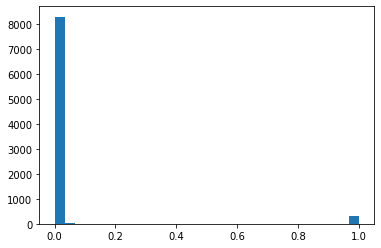

In [ ]:
plt.hist(val_preds[~is_spam_index_], bins=30)
plt.show()

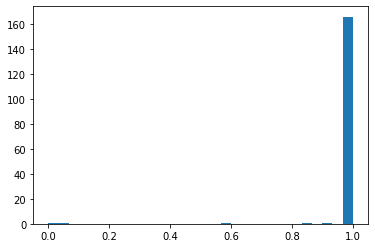

In [ ]:
plt.hist(val_preds[is_spam_index_], bins=30)
plt.show()

In [ ]:
# Pred Value Counts ------------------------------------------------------------
print("Value Counts (0: ham, 1: spam):")
print("-- Validation:")
print(pd.Series(np.where(val_preds>0.5, 1, 0)).value_counts())
print("-- Test:")
print(pd.Series(np.where(preds_mean>0.5, 1, 0)).value_counts().sort_index())
print()

# Threshold --------------------------------------------------------------------
# threshold for pseudo labeling.
#  * pseudo ham < threshold
#  * threshold <= unkown <= 1-threshold
#  * 1 - threshold < pseudo spam

threshold = 0.01

is_spam_conf = preds_mean > (1-threshold)
is_not_spam_conf = preds_mean < threshold
is_unkown = ~(is_spam_conf | is_not_spam_conf)

print("# of high confidence spam:", is_spam_conf.sum())
print("# of high confidence ham:", is_not_spam_conf.sum())
print("Unkown:", is_unkown.sum(), "/", len(preds_mean), f"({is_unkown.sum() / len(preds_mean) * 100 :.2f} %)")

Value Counts (0: ham, 1: spam):
-- Validation:
0    8354
1     524
dtype: int64
-- Test:
0     7952
1    16886
dtype: int64

# of high confidence spam: 14840
# of high confidence ham: 6723
Unkown: 3275 / 24838 (13.19 %)


In [ ]:
# pseudo_df = test_df.loc[is_spam_conf|is_not_spam_conf].copy().reset_index(drop=True)
pseudo_df = test_df.copy()
pseudo_df["y"] = 0
pseudo_df.loc[is_spam_conf, "y"] = 1
pseudo_df = pseudo_df.loc[is_spam_conf|is_not_spam_conf].reset_index(drop=True)

In [ ]:
pseudo_df

,id,contents,y
0,1,Subject: re : weather and energy price data\r\...,0
1,2,Subject: organizational study\r\ngpg and eott ...,0
2,3,Subject: re [ 7 ] : talk about our meds\r\nske...,1
3,4,Subject: report about your cable service\r\nhi...,1
4,5,Subject: start date : 1 / 26 / 02 ; hourahead ...,0
...,...,...,...
21558,24832,"Subject: rolex , cartier , piaget replicas - e...",1
21559,24834,Subject: savvy players would be wise to | 0 ad...,1
21560,24836,Subject: meter 9699\r\njackie -\r\ni cannot fo...,0
21561,24837,Subject: presentation for cal berkeley\r\nhell...,0


---
<h2>STEP 2</h2>

In [ ]:
pseudo_train_df = pd.concat([train_df, pseudo_df], axis=0)

In [ ]:
# trainデータを分割
X = pd.DataFrame(pseudo_train_df['contents'])
y = pd.DataFrame(pseudo_train_df['y'])

In [ ]:
y["y"].value_counts()

0    15430
1    15011
Name: y, dtype: int64

In [ ]:
# Parameter --------------------------------------------------------------------
n_splits = 5

# tokenizer 
tokenizer_name = None
tokenizer_params = {}

# vectorizer
vectorizer_name = "CountVectorizer"
vectorizer_params = {
    "min_df": 2, "ngram_range": (1, 2),
    "stop_words": "english"}

# model
model_name = "MultinomialNB"
model_params = {}
model_fit_params = {}

In [ ]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
train_preds = []
preds = []
oof_pred = np.zeros(len(X))
preprocessor = Preprocessor()

# for i in range(5):
for train_index, val_index in kf.split(X):
  # print(train_index, val_index)

  # # アンダーサンプリングしながら訓練用データの作成
  # sampler = RandomUnderSampler(random_state=SEED+i)
  # X_resampled, y_resampled = sampler.fit_resample(X,y)

  # # 検証用データの作成（random_stateを変えて取得）
  # sampler = RandomUnderSampler(random_state=SEED+i+10)
  # X_val, y_val = sampler.fit_resample(X,y)
  X_resampled, y_resampled = X["contents"].values[train_index], y["y"].values[train_index]
  X_val, y_val = X["contents"].values[val_index], y["y"].values[val_index]

  # preprocess
  X_resampled = preprocessor.preprocess(X_resampled)
  X_val = preprocessor.preprocess(X_val)

  # tokenizer
  if tokenizer_name:
    tokenizer = tokenizer_cls_dict[tokenizer_name](**tokenizer_params)
    tokenizer.fit(X_resampled)
  else:
    tokenizer = None

  # vectorizer
  vectorizer = vectorizer_cls_dict[vectorizer_name](tokenizer=tokenizer, **vectorizer_params)
  vectorizer.fit(X_resampled)

  # 単語の出現回数取得
  # 単語の種類の表示
  print('word size: ', len(vectorizer.vocabulary_))
  # 先頭５件の単語を表示
  print('word content: ', dict(list(vectorizer.vocabulary_.items())[0:5]))

  # 訓練データと検証データをベクトル化
  X_resampled_vec = vectorizer.transform(X_resampled)
  X_val_vec = vectorizer.transform(X_val)

  # ベルヌーイモデルで学習
  model = model_cls_dict[model_name](**model_params)
  model.fit(X_resampled_vec, y_resampled, **model_fit_params)

  val_pred = model.predict(X_val_vec)
  oof_pred[val_index] = val_pred

  # F1スコアのprint
  print("val_F1-score",f1_score(val_pred, y_val))
  print("------------------------------------------------------------------------------------------------------------------")

  # for train ------------------------------------------------------------------
  input_vec = vectorizer.transform(preprocessor.preprocess(train_df['contents'].values))
  train_preds.append(model.predict_proba(input_vec))

  # for test -------------------------------------------------------------------
  # testデータをベクトル化
  # df_data = pd.DataFrame(test, columns=['contents'])
  input_vec = vectorizer.transform(preprocessor.preprocess(test_df['contents'].values))

  # testの予測→seed毎に空のリストに格納
  pred = model.predict_proba(input_vec)
  preds.append(pred)

print("val_F1-oof score",f1_score(oof_pred, y["y"].values))
print()

# トレーニングデータを使ったバリデーション =====================================
train_preds = np.array(train_preds)[:, :, 1]
train_preds_mean = train_preds.mean(axis=0)
train_pred = np.where(train_preds_mean > 0.5, 1, 0)
train_true = train_df["y"].values

# Classification Report --------------------------------------------------------
print()
print(classification_report(train_true, train_pred, digits=4, target_names=["not_spam", "spam"]))
print("oof_F1-score",f1_score(train_true, train_pred))
print()
# resampled classification report
n_sample_not_spam_index = int(len(is_spam_index) * test_not_spam_ration)
sample_not_spam_index = np.random.choice(is_not_spam_index, n_sample_not_spam_index, replace=False)
sample_index = np.concatenate((sample_not_spam_index, is_spam_index))
print("resampled:")
print(classification_report(train_true[sample_index], train_pred[sample_index], digits=4, target_names=["not_spam", "spam"]))
print("resampled oof_F1-score",f1_score(train_true[sample_index], train_pred[sample_index]))
print()

# Average resampled F1 score ---------------------------------------------------
sample_scores = []
n_sample_scores = 100  # Nunmber of downsampled F1 scores
for i in range(n_sample_scores):
  n_sample_not_spam_index = int(len(is_spam_index) * test_not_spam_ration)
  sample_not_spam_index = np.random.choice(is_not_spam_index, n_sample_not_spam_index, replace=False)
  sample_index = np.concatenate((sample_not_spam_index, is_spam_index))
  # print("resampled:")
  # print(classification_report(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0), digits=4, target_names=["not_spam", "spam"]))
  sample_score = f1_score(train_true[sample_index], train_pred[sample_index])
  # print("resampled oof_F1-score",sample_score)
  sample_scores.append(sample_score)
print("sample f1 scores:", sample_scores)
print("mean sample f1 score:", np.mean(sample_scores))
# ==============================================================================
print()
# To Numpy Array ---------------------------------------------------------------
preds = np.array(preds)
preds = preds[:, :, 1]

preds_mean = preds.mean(axis=0)

# Pred Value Counts ------------------------------------------------------------
print("Value Counts (0: ham, 1: spam):")
print("-- single pred:")
print(pd.Series(np.where(pred[:, 1]>0.5, 1, 0)).value_counts().sort_index())
print("-- mean pred:")
print(pd.Series(np.where(preds_mean>0.5, 1, 0)).value_counts().sort_index())
print()

word size:  459691
word content:  {'fw': 185150, 'willis': 449757, 'phillips': 313310, 'just': 232736, 'spoke': 391304}
val_F1-score 0.997020854021847
------------------------------------------------------------------------------------------------------------------
word size:  461323
word content:  {'fw': 186482, 'willis': 451350, 'phillips': 314855, 'just': 234234, 'spoke': 392839}
val_F1-score 0.996282527881041
------------------------------------------------------------------------------------------------------------------
word size:  460113
word content:  {'factor': 169082, 'loadings': 250071, 'primary': 328657, 'curves': 118761, 'tanya': 408733}
val_F1-score 0.9945945945945946
------------------------------------------------------------------------------------------------------------------
word size:  456540
word content:  {'fw': 183521, 'willis': 446458, 'phillips': 311176, 'just': 231003, 'spoke': 388648}
val_F1-score 0.994849642797807
-------------------------------------------

In [ ]:
threshold = 0.01

is_spam_conf = preds_mean > (1-threshold)
is_not_spam_conf = preds_mean < threshold
is_unkown = ~(is_spam_conf | is_not_spam_conf)

print("# of high confidence spam:", is_spam_conf.sum())
print("# of high confidence ham:", is_not_spam_conf.sum())
print("Unkown:", is_unkown.sum(), "/", len(preds_mean), f"({is_unkown.sum() / len(preds_mean) * 100 :.2f} %)")

# of high confidence spam: 16372
# of high confidence ham: 7808
Unkown: 658 / 24838 (2.65 %)


In [ ]:
# pseudo_df = test_df.loc[is_spam_conf|is_not_spam_conf].copy().reset_index(drop=True)
pseudo_df = test_df.copy()
pseudo_df["y"] = 0
pseudo_df.loc[is_spam_conf, "y"] = 1
pseudo_df = pseudo_df.loc[is_spam_conf|is_not_spam_conf].reset_index(drop=True)

In [ ]:
pseudo_df

,id,contents,y
0,1,Subject: re : weather and energy price data\r\...,0
1,2,Subject: organizational study\r\ngpg and eott ...,0
2,3,Subject: re [ 7 ] : talk about our meds\r\nske...,1
3,4,Subject: report about your cable service\r\nhi...,1
4,5,Subject: start date : 1 / 26 / 02 ; hourahead ...,0
...,...,...,...
24175,24834,Subject: savvy players would be wise to | 0 ad...,1
24176,24835,Subject: it ' s mariah from dating service\r\n...,1
24177,24836,Subject: meter 9699\r\njackie -\r\ni cannot fo...,0
24178,24837,Subject: presentation for cal berkeley\r\nhell...,0


---
<h2> STEP 3</h2>

In [ ]:
pseudo_train_df = pd.concat([train_df, pseudo_df], axis=0)

In [ ]:
# trainデータを分割
X = pd.DataFrame(pseudo_train_df['contents'])
y = pd.DataFrame(pseudo_train_df['y'])

In [ ]:
y["y"].value_counts()

1    16543
0    16515
Name: y, dtype: int64

In [ ]:
# Parameter --------------------------------------------------------------------
n_splits = 5

# tokenizer 
tokenizer_name = None
tokenizer_params = {}

# vectorizer
vectorizer_name = "CountVectorizer"
vectorizer_params = {
    "min_df": 2, "ngram_range": (1, 2),
    "stop_words": "english"}

# model
model_name = "MultinomialNB"
model_params = {}
model_fit_params = {}

In [ ]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
train_preds = []
preds = []
oof_pred = np.zeros(len(X))
preprocessor = Preprocessor()

# for i in range(5):
for train_index, val_index in kf.split(X):
  # print(train_index, val_index)

  # # アンダーサンプリングしながら訓練用データの作成
  # sampler = RandomUnderSampler(random_state=SEED+i)
  # X_resampled, y_resampled = sampler.fit_resample(X,y)

  # # 検証用データの作成（random_stateを変えて取得）
  # sampler = RandomUnderSampler(random_state=SEED+i+10)
  # X_val, y_val = sampler.fit_resample(X,y)
  X_resampled, y_resampled = X["contents"].values[train_index], y["y"].values[train_index]
  X_val, y_val = X["contents"].values[val_index], y["y"].values[val_index]

  # preprocess
  X_resampled = preprocessor.preprocess(X_resampled)
  X_val = preprocessor.preprocess(X_val)

  # tokenizer
  if tokenizer_name:
    tokenizer = tokenizer_cls_dict[tokenizer_name](**tokenizer_params)
    tokenizer.fit(X_resampled)
  else:
    tokenizer = None

  # vectorizer
  vectorizer = vectorizer_cls_dict[vectorizer_name](tokenizer=tokenizer, **vectorizer_params)
  vectorizer.fit(X_resampled)

  # 単語の出現回数取得
  # 単語の種類の表示
  print('word size: ', len(vectorizer.vocabulary_))
  # 先頭５件の単語を表示
  print('word content: ', dict(list(vectorizer.vocabulary_.items())[0:5]))

  # 訓練データと検証データをベクトル化
  X_resampled_vec = vectorizer.transform(X_resampled)
  X_val_vec = vectorizer.transform(X_val)

  # ベルヌーイモデルで学習
  model = model_cls_dict[model_name](**model_params)
  model.fit(X_resampled_vec, y_resampled, **model_fit_params)

  val_pred = model.predict(X_val_vec)
  oof_pred[val_index] = val_pred

  # F1スコアのprint
  print("val_F1-score",f1_score(val_pred, y_val))
  print("------------------------------------------------------------------------------------------------------------------")

  # for train ------------------------------------------------------------------
  input_vec = vectorizer.transform(preprocessor.preprocess(train_df['contents'].values))
  train_preds.append(model.predict_proba(input_vec))

  # for test -------------------------------------------------------------------
  # testデータをベクトル化
  # df_data = pd.DataFrame(test, columns=['contents'])
  input_vec = vectorizer.transform(preprocessor.preprocess(test_df['contents'].values))

  # testの予測→seed毎に空のリストに格納
  pred = model.predict_proba(input_vec)
  preds.append(pred)

print("val_F1-oof score",f1_score(oof_pred, y["y"].values))
print()

# トレーニングデータを使ったバリデーション =====================================
train_preds = np.array(train_preds)[:, :, 1]
train_preds_mean = train_preds.mean(axis=0)
train_pred = np.where(train_preds_mean > 0.5, 1, 0)
train_true = train_df["y"].values

# Classification Report --------------------------------------------------------
print()
print(classification_report(train_true, train_pred, digits=4, target_names=["not_spam", "spam"]))
print("oof_F1-score",f1_score(train_true, train_pred))
print()
# resampled classification report
n_sample_not_spam_index = int(len(is_spam_index) * test_not_spam_ration)
sample_not_spam_index = np.random.choice(is_not_spam_index, n_sample_not_spam_index, replace=False)
sample_index = np.concatenate((sample_not_spam_index, is_spam_index))
print("resampled:")
print(classification_report(train_true[sample_index], train_pred[sample_index], digits=4, target_names=["not_spam", "spam"]))
print("resampled oof_F1-score",f1_score(train_true[sample_index], train_pred[sample_index]))
print()

# Average resampled F1 score ---------------------------------------------------
sample_scores = []
n_sample_scores = 100  # Nunmber of downsampled F1 scores
for i in range(n_sample_scores):
  n_sample_not_spam_index = int(len(is_spam_index) * test_not_spam_ration)
  sample_not_spam_index = np.random.choice(is_not_spam_index, n_sample_not_spam_index, replace=False)
  sample_index = np.concatenate((sample_not_spam_index, is_spam_index))
  # print("resampled:")
  # print(classification_report(y.loc[sample_index, "y"].values, np.where(val_preds[sample_index]>0.5, 1, 0), digits=4, target_names=["not_spam", "spam"]))
  sample_score = f1_score(train_true[sample_index], train_pred[sample_index])
  # print("resampled oof_F1-score",sample_score)
  sample_scores.append(sample_score)
print("sample f1 scores:", sample_scores)
print("mean sample f1 score:", np.mean(sample_scores))
# ==============================================================================
print()
# To Numpy Array ---------------------------------------------------------------
preds = np.array(preds)
preds = preds[:, :, 1]

preds_mean = preds.mean(axis=0)

# Pred Value Counts ------------------------------------------------------------
print("Value Counts (0: ham, 1: spam):")
print("-- single pred:")
print(pd.Series(np.where(pred[:, 1]>0.5, 1, 0)).value_counts().sort_index())
print("-- mean pred:")
print(pd.Series(np.where(preds_mean>0.5, 1, 0)).value_counts().sort_index())
print()

word size:  525083
word content:  {'fw': 211393, 'willis': 513771, 'phillips': 357405, 'just': 265451, 'spoke': 447086}
val_F1-score 0.9979240806642943
------------------------------------------------------------------------------------------------------------------
word size:  521948
word content:  {'fw': 210493, 'willis': 510888, 'phillips': 355467, 'just': 264140, 'spoke': 445038}
val_F1-score 0.9971552627638868
------------------------------------------------------------------------------------------------------------------
word size:  535693
word content:  {'factor': 196251, 'loadings': 290698, 'primary': 381552, 'curves': 137762, 'tanya': 475389}
val_F1-score 0.996768733651331
------------------------------------------------------------------------------------------------------------------
word size:  523733
word content:  {'fw': 211299, 'willis': 512513, 'phillips': 357124, 'just': 265364, 'spoke': 446443}
val_F1-score 0.9967884997706071
-----------------------------------------

In [ ]:
def top_k_index(array, k):
  # ソートはされていない上位k件のインデックス
  unsorted_max_indices = np.argpartition(-array, k)[:k]
  # 上位k件の値
  y = array[unsorted_max_indices]
  # 大きい順にソートし、インデックスを取得
  indices = np.argsort(-y)
  # 類似度上位k件のインデックス
  max_k_indices = unsorted_max_indices[indices]
  return max_k_indices

In [ ]:
top_index = top_k_index(preds_mean.copy(), n_test_spam)

In [ ]:
sub = pd.DataFrame(test_df["id"])
sub["y"] = pd.Series(np.where(preds_mean>0.5, 1, 0))

In [ ]:
sub["y"].value_counts()

1    16867
0     7971
Name: y, dtype: int64

In [ ]:
sub.loc[top_index, "y"] = 1

In [ ]:
sub["y"].value_counts()

1    17000
0     7838
Name: y, dtype: int64

In [ ]:
sub

,id,y
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0
...,...,...
24833,24834,1
24834,24835,1
24835,24836,0
24836,24837,0


In [ ]:
sub.to_csv("submit.csv",index=False)